In [ ]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pickle

In [ ]:
def fDOST(h: np.ndarray, f = None):
    n = len(h)
    H = np.fft.fft(h, norm='ortho')
    S = np.zeros(n//2, dtype=complex)

    S[0] = H[0]
    S[1] = -H[1] # simplifies to -1: np.exp(-2j*(n//2) * np.pi/n)

    for p in range(2, int(np.log2(n))):
        b = 2**(p-1)
        v = b + 2**(p-2)
        k = np.arange(v - b//2, v + b//2)
        tau = np.arange(b)

        R = np.exp(-2j*np.pi*tau/2)
        V = np.fft.ifft(H[k], norm='ortho')

        T = R*V
        S[b: 2*b] = T
        if f != None:
            if b >= f:
                break
    
    if f!= None:
        S = S[:f]

    return S

def fdost2m(arr: np.ndarray, f: int = None):
    #positive values only
    n = len(arr)
    m = np.zeros((n, n*2), dtype=complex)

    m[0] = arr[0]
    m[1] = arr[1]

    index = 2
    n*=2
    for i in range(1,int(np.log2(n//2))):
        k = 2**i
        j = n//k
        for p in range(k):
            m[index:index+k, j*p:j*(p+1)] = arr[index+p]
        index+=k
        if k != None:
            if index >= f:
                break
    
    if k != None:
        m = m[:f]

    return m


def plt_fdost(m, f = None):
    if f == None:
        f = m.shape[0]
    else:
        m = m[:f]
    plt.figure(figsize=(10,6))
    plt.imshow(np.abs(m), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.tight_layout()
    plt.yscale('log')
    plt.ylim(0.05, f)
    plt.show()


In [3]:
client = Client("IRIS")
client2 = Client("SCEDC")

In [4]:
# 12/25/09 8:59
# 1/27/25 9:00
# 12/25/18 8:59
# 12/25/18 8:59
# 7/1/08 9:00
# 12/25/18 8:59
# 12/25/18 8:59
# 1/27/25 9:00
# 12/25/08 8:59
# 1/27/25 9:00
# 12/25/10 9:00
# 12/25/24 8:59
t1 = UTCDateTime("2008-07-01:08:59.590")
t2 = UTCDateTime("2008-12-25:08:59.590") 
t3 = UTCDateTime("2009-12-25:08:59.590") 
t4 = UTCDateTime("2010-12-25:08:59.590") 
t5 = UTCDateTime("2018-12-25:08:59.590") 
t6 = UTCDateTime("2024-12-25:08:59.590") 
t7 = UTCDateTime("2025-01-27:08:59.590") 

In [5]:
dtbf = 10
# dtaft = 8760 # (146 mins)
dtaft = 200 # (3.3 mins)

In [6]:
station_code = ['BHP','DJJ','GR2','LAF','LCG','LTP','PDR','SMF2','SMS','USC','WTT','WTT2']
time_stamp = [t3,t7,t5,t5,t1,t5,t5,t7,t2,t7,t4,t6]
waveforms = []

In [7]:
for inx in range(len(station_code)):
    [network, station, location, channel, sbef, saft] = ["CI", station_code[inx], "*", "HH*", dtbf, dtaft]
    waveforms.append(client2.get_waveforms(network, station, location, channel, time_stamp[inx] - sbef, time_stamp[inx] + saft, attach_response = True))
    print(inx)

0
1
2
3
4
5
6
7
8
9
10
11


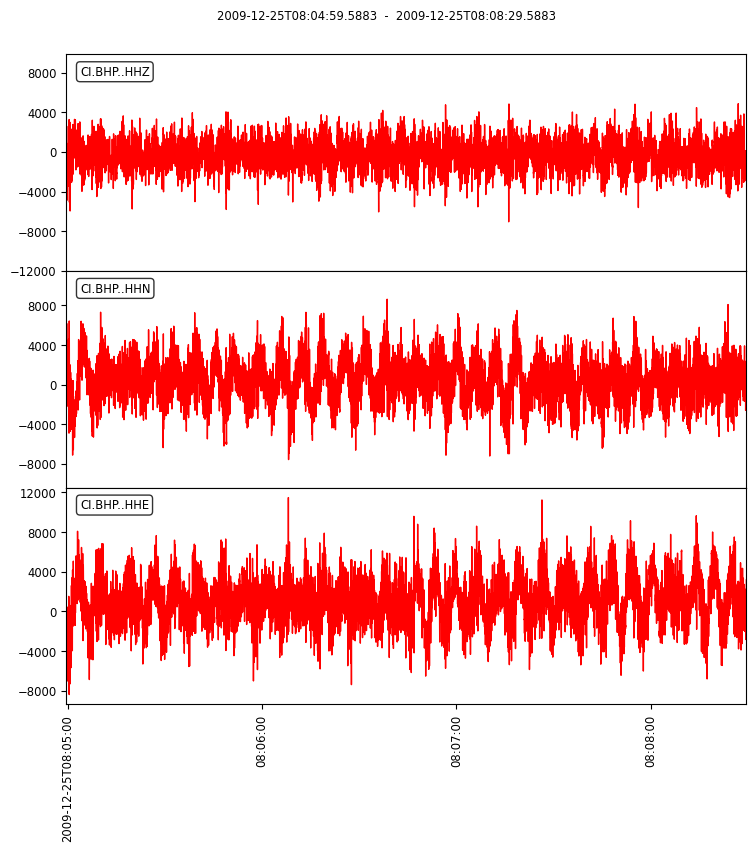

In [8]:
waveforms[0].plot(color='red',number_of_ticks=10,tick_format='%.2f',tick_rotation=90)
plt.show()

In [10]:
@dataclass
class StationTF:
    waveform: object
    stN: np.ndarray | None
    stE: np.ndarray | None
    stZ: np.ndarray | None

    mN: np.ndarray | None
    mE: np.ndarray | None
    mZ: np.ndarray | None

    HVSR: np.ndarray | None
    

res = []
f = 100

for st in waveforms:
    trN = st.select(component="N")
    trE = st.select(component="E")
    trZ = st.select(component="Z")

    dataN = trN[0].data if trN else None
    dataE = trE[0].data if trE else None
    dataZ = trZ[0].data if trZ else None

    n = len(dataN)
    pow2 = 2 ** int(np.floor(np.log2(n)))

    stN = fDOST(dataN[:pow2], f) if dataN is not None else None
    stE = fDOST(dataE[:pow2], f) if dataE is not None else None
    stZ = fDOST(dataZ[:pow2], f) if dataZ is not None else None

    mN = fdost2m(stN, f)
    mE = fdost2m(stE, f)
    mZ = fdost2m(stZ, f)

    hvsr = (stN + stE)/stZ
    HVSR = fdost2m(hvsr, f)

    res.append(StationTF(waveform=st, stN=stN, stE=stE, stZ=stZ, mN=mN, mE=mE, mZ=mZ, HVSR=HVSR))

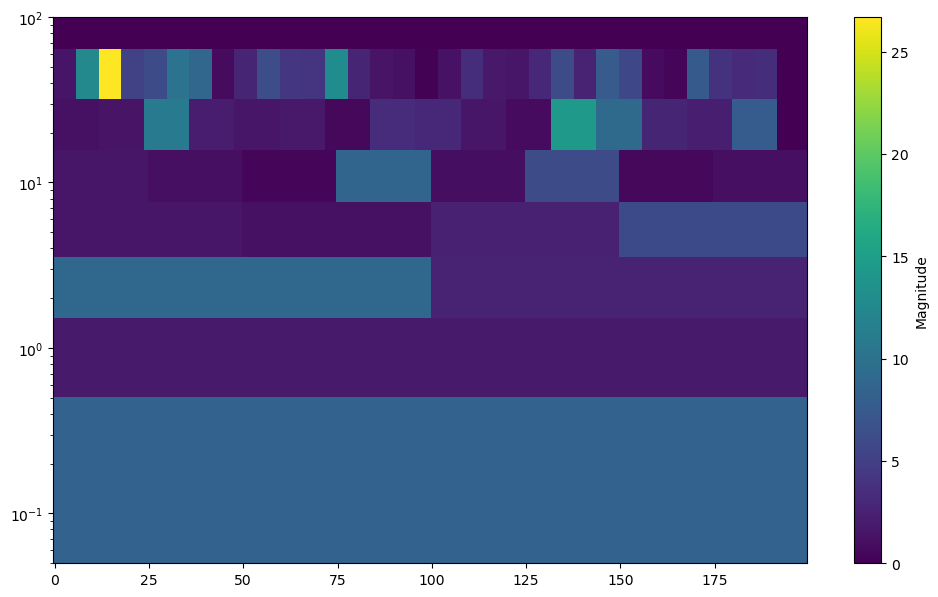

In [11]:
plt_fdost(res[1].HVSR)

In [ ]:
with open("results.pkl", "wb") as f:
    pickle.dump(res, f)

In [13]:
with open("results.pkl", "rb") as f:
    res = pickle.load(f)

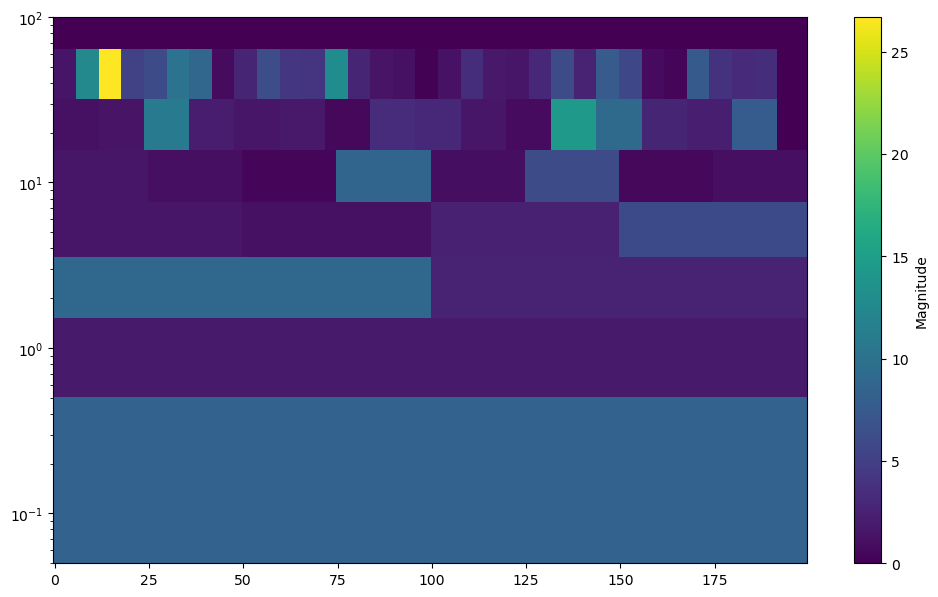

In [ ]:
plt_fdost(res[1].HVSR)